In [42]:
# Fashion MNIST 데이터셋 불러오기

import torch
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

In [43]:
# 훈련/테스트 세트

train_input = fm_train.data
train_target = fm_train.targets

test_input = fm_test.data
test_target = fm_test.targets

In [44]:
# 이미지 입력 - 채널 명시 (배치, 채널, 높이, 너비)
train_input = train_input.reshape(-1, 1, 28, 28)
test_input = test_input.reshape(-1, 1, 28, 28)

# 정규화
train_scaled = train_input / 255.0
test_scaled = test_input / 255.0

In [45]:
# 훈련/검증 세트 분리

from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [46]:
# 층 구성

import torch
import torch.nn as nn

model = nn.Sequential()

# 합성곱 층 1
model.add_module("conv1", nn.Conv2d(1, 32, 3, padding='same'))
model.add_module("relu1", nn.ReLU())  # 풀링 전에 활성화 함수 설정하는 것을 잊지 말자!
                                      # - 활성화 함수까지 통과 시키고 나서야 특성맵이 만들어진다
model.add_module("pool1", nn.MaxPool2d(2))

# 합성곱 층 2
model.add_module("conv2", nn.Conv2d(32, 64, 3, padding='same'))
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(2))

# Flatten 층
model.add_module('flatten', nn.Flatten())

# 은닉층 입력 크기 확인
outputs = model(torch.ones(1, 1, 28, 28))  # 가짜 데이터를 넣어서 입력 데이터가 몇 개인지 확인
print(outputs.shape)  # torch.Size([1, 3136]) -> 3136개

# 은닉층
model.add_module('dense1', nn.Linear(7 * 7 * 64, 100))  # 3136, 100
model.add_module("relu3", nn.ReLU())
model.add_module("dropout", nn.Dropout(0.3))

# 출력층
model.add_module("dense2", nn.Linear(100, 10))

torch.Size([1, 3136])


In [47]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            320
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            313,700
├─ReLU: 1-9                              --
├─Dropout: 1-10                          --
├─Linear: 1-11                           1,010
Total params: 333,526
Trainable params: 333,526
Non-trainable params: 0

In [48]:
# GPU or CPU 결정 후 모델에 연결
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=3136, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=100, out_features=10, bias=True)
)

In [49]:
# optimizer, loss func

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [50]:
# TensorDataset, DataLoader

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_scaled, train_target)
val_dataset = TensorDataset(val_scaled, val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [51]:
# 모델 훈련

# 필요한 변수 선언
train_history = []  # 훈련 세트의 각 에포크마다의 loss값을 저장할 리스트
val_history = []    # 검증 세트의 각 에포크마다의 loss값을 저장할 리스트
patience = 2        # loss값이 상승해도 눈 감아줄 횟수
best_loss = 2       # 가장 낮은 loss값 저장 (기본값을 2로 설정, 어차피 loss는 0~1이기 때문)
early_stopping_counter = 0   # 조기 종료 카운트 (patience에 도달하면 조기 종료)
epochs = 20         # 훈련 반복 횟수: 20번
batches = int(len(train_scaled) / 32)  # 미니 배치 학습 반복 횟수 per 1 epoch (32개씩 반복)

# 훈련
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    train_loss_avg = train_loss / batches
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_history.append(train_loss_avg)  # 1 epoch 당 훈련 세트 손실값 평균
    val_history.append(val_loss)          # 1 epoch 당 검증 세트 손실값

    print(f"epochs: {epoch + 1}, loss: {train_loss_avg:.4f}, val_loss: {val_loss:.4f}")

    # 현재 에포크의 검증 손실이 기존 검증 손실보다 작은 경우 - 더 좋은 것이므로 손실값 업데이트
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0  # 조기 종료 카운트를 초기화
        torch.save(model.state_dict(), "best_cnn_model.pth")  # 모델의 가중치만 저장
        # 파이토치는 keras와 다르게 전체 모델을 저장할 일은 없다. 매번 모델 재구성해서 복구해야 함.
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}번째 에포크에서 조기 종료되었습니다.")
            break  # 반복 종료

epochs: 1, loss: 0.5388, val_loss: 0.3411
epochs: 2, loss: 0.3566, val_loss: 0.3092
epochs: 3, loss: 0.3062, val_loss: 0.2836
epochs: 4, loss: 0.2728, val_loss: 0.2516
epochs: 5, loss: 0.2453, val_loss: 0.2361
epochs: 6, loss: 0.2214, val_loss: 0.2236
epochs: 7, loss: 0.2046, val_loss: 0.2273
epochs: 8, loss: 0.1892, val_loss: 0.2355
8번째 에포크에서 조기 종료되었습니다.


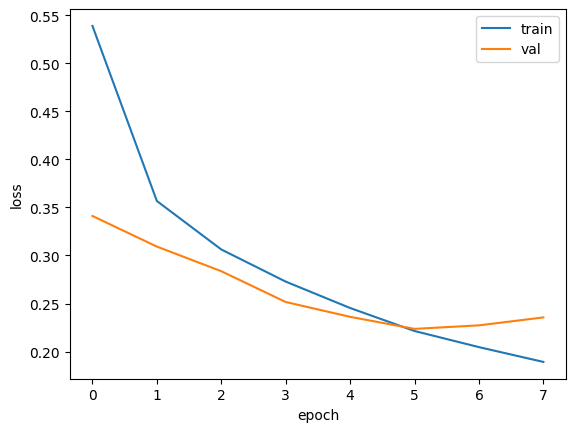

In [52]:
import matplotlib.pyplot as plt

# 검증 세트의 loss 경향성 그래프 그리기
plt.plot(train_history, label='train') # 훈련 세트의 loss
plt.plot(val_history, label='val')     # 검증 세트의 loss

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

In [53]:
# 모델 가중치 불러오기 
model.load_state_dict(torch.load('best_cnn_model.pth',  weights_only=True))

<All keys matched successfully>

In [54]:
# 검증 세트의 loss(손실값), accuracy(정확도)
model.eval()
corrects = 0
val_loss = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = torch.argmax(outputs, 1)
        # print(predicts[:10])
        corrects += (predicts == targets).sum().item()

        loss = criterion(outputs, targets)
        val_loss += loss.item()

accuracy = corrects / len(val_target)
val_loss = val_loss / len(val_loader)
print(f"val_accuracy: {accuracy:.4f}, val_loss: {loss.item():.4f}")

val_accuracy: 0.9154, val_loss: 0.2797
